# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.8.3'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science for Social Impact research group, University of Pretoria (2020), https://github.

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science for Social Impact research group, University of Pretoria (2020), https://github.

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
253103,2020-09-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253104,2020-09-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253105,2020-09-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253106,2020-09-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253107,2020-09-21,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
253103,2020-09-17,Colombia,Vichada,14,0,0,14
253104,2020-09-18,Colombia,Vichada,14,0,0,14
253105,2020-09-19,Colombia,Vichada,14,0,0,14
253106,2020-09-20,Colombia,Vichada,14,0,0,14
253107,2020-09-21,Colombia,Vichada,14,0,0,14


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
182,2020-09-17,23608,2382,389,20837
183,2020-09-18,23828,2417,390,21021
184,2020-09-19,24046,2448,390,21208
185,2020-09-20,24208,2440,390,21378
186,2020-09-21,24306,2443,391,21472


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-09-17,29926500,8676926,942209,20307365,0.015742,0.339287,0.044340
2020-09-18,30243459,8732254,947938,20563267,0.015672,0.339962,0.044067
2020-09-19,30535840,8788046,952795,20794999,0.015601,0.340502,0.043811
2020-09-20,30772281,8805120,956237,21010924,0.015537,0.341394,0.043530
2020-09-21,30772643,8804720,956244,21011679,0.015537,0.341402,0.043529


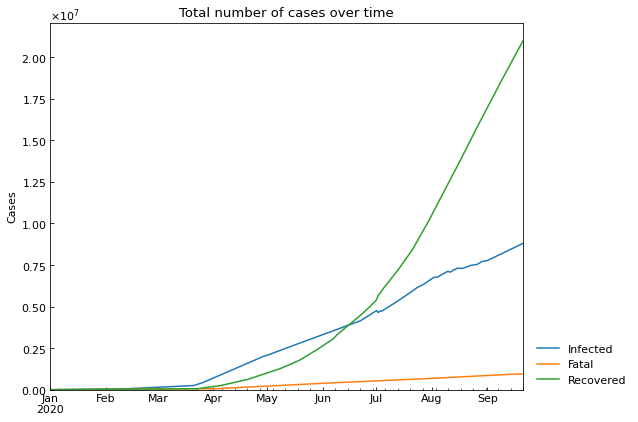

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
221,2020-09-17,77512,6801,1488,69223
222,2020-09-18,78084,6721,1498,69865
223,2020-09-19,78683,6745,1502,70436
224,2020-09-20,79163,6652,1506,71005
225,2020-09-21,79474,6583,1513,71378


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
219,2020-09-17,77009,6283,1473,69253
220,2020-09-18,77494,6113,1482,69899
221,2020-09-19,78073,6083,1495,70495
222,2020-09-20,78657,6127,1500,71030
223,2020-09-21,79140,6236,1500,71404


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
253103,2020-09-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253104,2020-09-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253105,2020-09-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253106,2020-09-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253107,2020-09-21,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
215257,COL,Colombia,Vichada,2020-09-17,107808
215258,COL,Colombia,Vichada,2020-09-18,107808
215259,COL,Colombia,Vichada,2020-09-19,107808
215260,COL,Colombia,Vichada,2020-09-20,107808
215261,COL,Colombia,Vichada,2020-09-21,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
253103,2020-09-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253104,2020-09-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253105,2020-09-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253106,2020-09-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
253107,2020-09-21,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
253103,2020-09-17,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
253104,2020-09-18,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
253105,2020-09-19,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
253106,2020-09-20,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
253107,2020-09-21,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
260,2020-09-17,1,1,1,0,0,1,1,3,2,2,1,37.04
261,2020-09-18,1,1,1,0,0,1,1,3,2,2,1,37.04
262,2020-09-19,1,1,1,0,0,1,1,3,2,2,1,37.04
263,2020-09-20,1,1,1,0,0,1,1,3,2,2,1,37.04
264,2020-09-21,1,1,1,0,0,1,1,3,2,2,1,37.04


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
260,2020-09-17,1,1,1,0,0,1,1,3,2,2,1,37.04
261,2020-09-18,1,1,1,0,0,1,1,3,2,2,1,37.04
262,2020-09-19,1,1,1,0,0,1,1,3,2,2,1,37.04
263,2020-09-20,1,1,1,0,0,1,1,3,2,2,1,37.04
264,2020-09-21,1,1,1,0,0,1,1,3,2,2,1,37.04


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

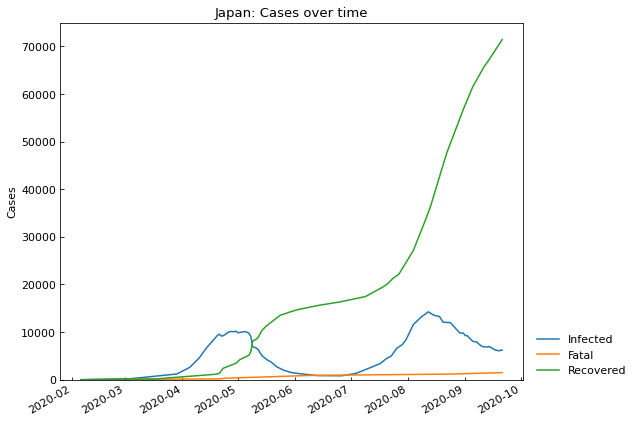

,Date,Confirmed,Infected,Fatal,Recovered
219,2020-09-17,77009,6283,1473,69253
220,2020-09-18,77494,6113,1482,69899
221,2020-09-19,78073,6083,1495,70495
222,2020-09-20,78657,6127,1500,71030
223,2020-09-21,79140,6236,1500,71404


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

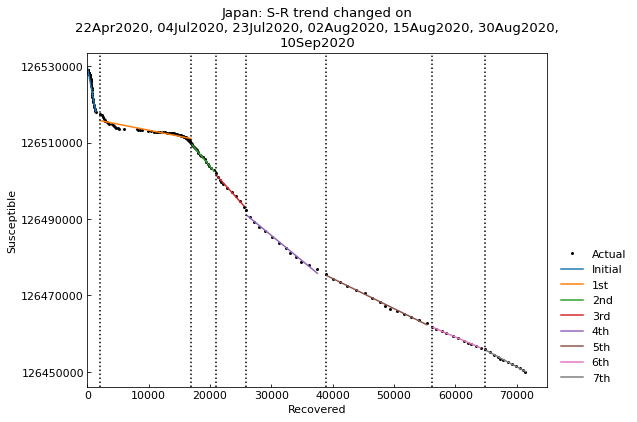

,Type,Start,End,Population
0th,Past,06Feb2020,21Apr2020,126529100
1st,Past,22Apr2020,03Jul2020,126529100
2nd,Past,04Jul2020,22Jul2020,126529100
3rd,Past,23Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,14Aug2020,126529100
5th,Past,15Aug2020,29Aug2020,126529100
6th,Past,30Aug2020,09Sep2020,126529100
7th,Past,10Sep2020,21Sep2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	7th phase (10Sep2020 - 21Sep2020): finished  301 trials in 0 min 10 sec

	0th phase (06Feb2020 - 21Apr2020): finished 1376 trials in 1 min  0 sec

	2nd phase (04Jul2020 - 22Jul2020): finished 1487 trials in 1 min  0 sec

	1st phase (22Apr2020 - 03Jul2020): finished 1425 trials in 1 min  0 sec

	3rd phase (23Jul2020 - 01Aug2020): finished 1505 trials in 1 min  0 sec

	5th phase (15Aug2020 - 29Aug2020): finished  210 trials in 0 min  5 sec

	6th phase (30Aug2020 - 09Sep2020): finished  216 trials in 0 min  5 sec

	4th phase (02Aug2020 - 14Aug2020): finished 1812 trials in 1 min  0 sec

Completed optimization. Total: 2 min 11 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/alpha2 [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,21Apr2020,126529100,SIR-F,4.88,0.000120,0.000594,0.025352,0.004603,360,0.000,9,420,54,0.929576,1376,1 min 0 sec
1st,Past,22Apr2020,03Jul2020,126529100,SIR-F,0.40,0.084350,0.000186,0.007572,0.017066,360,0.084,33,1341,14,0.793123,1425,1 min 0 sec
2nd,Past,04Jul2020,22Jul2020,126529100,SIR-F,2.08,0.001088,0.000026,0.035503,0.017018,360,0.001,7,9563,14,0.039275,1487,1 min 0 sec
3rd,Past,23Jul2020,01Aug2020,126529100,SIR-F,2.06,0.000938,0.000031,0.035897,0.017340,360,0.001,6,7997,14,0.035086,1505,1 min 0 sec
4th,Past,02Aug2020,14Aug2020,126529100,SIR-F,1.35,0.000487,0.000106,0.024741,0.018217,360,0.000,10,2362,13,0.092902,1812,1 min 0 sec
5th,Past,15Aug2020,29Aug2020,126529100,SIR-F,0.79,0.001486,0.000191,0.021101,0.026370,360,0.001,11,1308,9,0.033618,210,0 min 5 sec
6th,Past,30Aug2020,09Sep2020,126529100,SIR-F,0.62,0.017282,0.000149,0.016330,0.025938,360,0.017,15,1679,9,0.048598,216,0 min 5 sec
7th,Past,10Sep2020,21Sep2020,126529100,SIR-F,0.89,0.002022,0.000294,0.022666,0.025093,360,0.002,11,850,9,0.018654,301,0 min 10 sec


### Accuracy of estimation

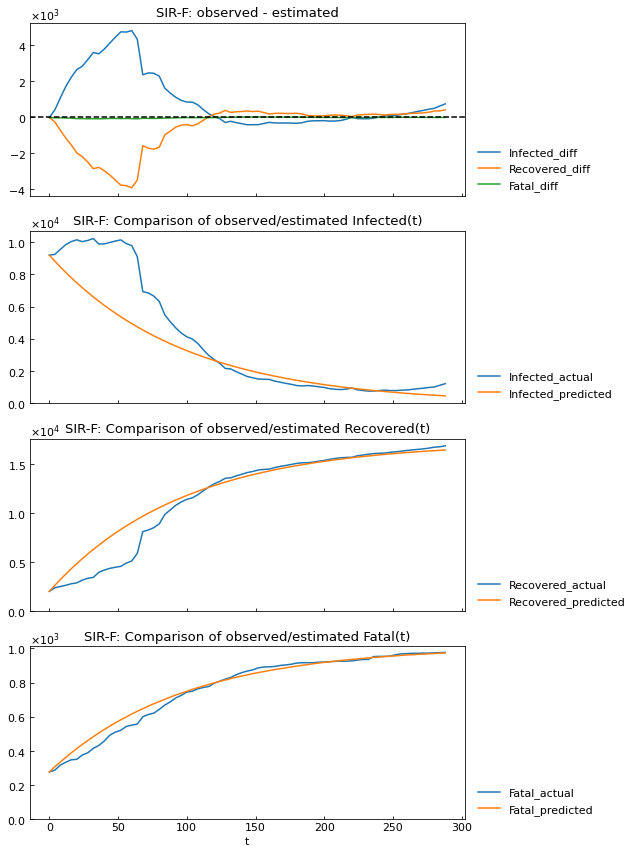

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.35

### Show parameter history

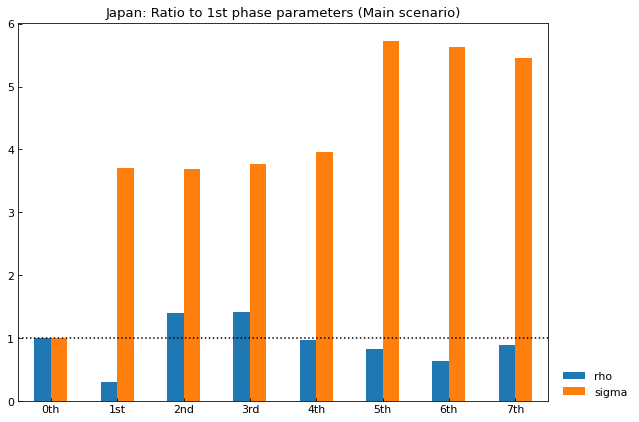

,0th,1st,2nd,3rd,4th,5th,6th,7th
rho,1.0,0.298682,1.400388,1.415921,0.975878,0.832326,0.644102,0.894052
sigma,1.0,3.707838,3.697466,3.767398,3.957905,5.729327,5.635464,5.451810


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

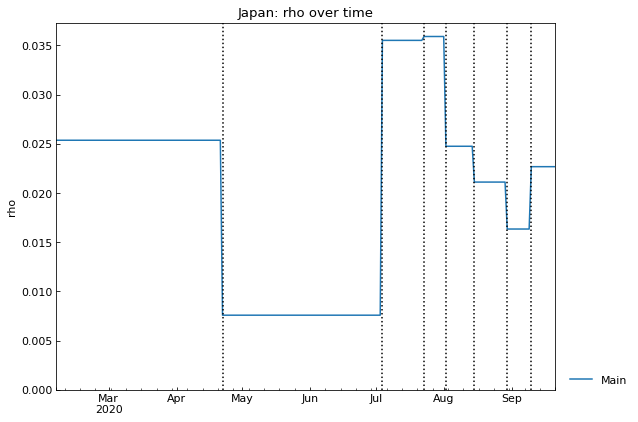

In [33]:
# version >= 2.8.0
_ = scenario.history(target="rho")

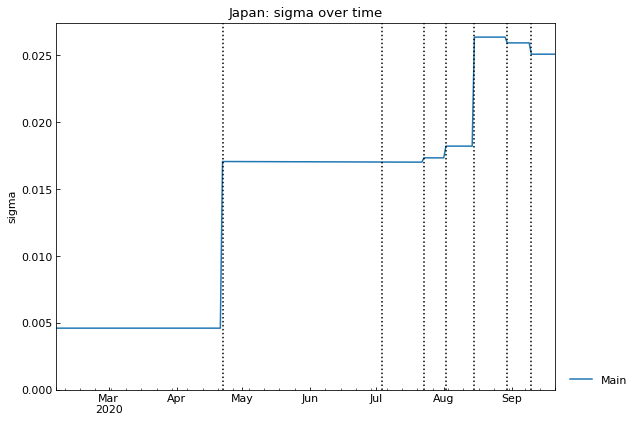

In [34]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

### Show the history of reproduction number

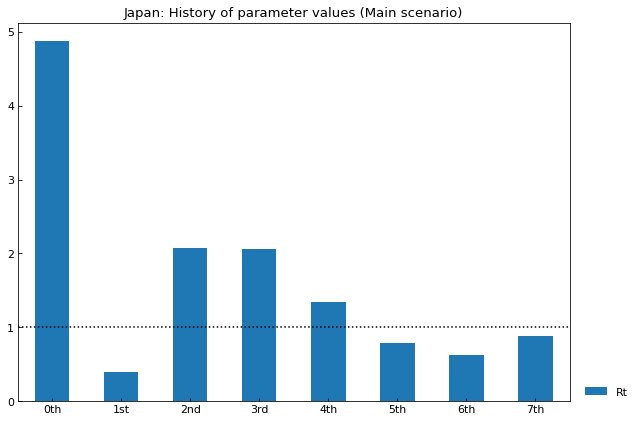

,0th,1st,2nd,3rd,4th,5th,6th,7th
Rt,4.88,0.4,2.08,2.06,1.35,0.79,0.62,0.89


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

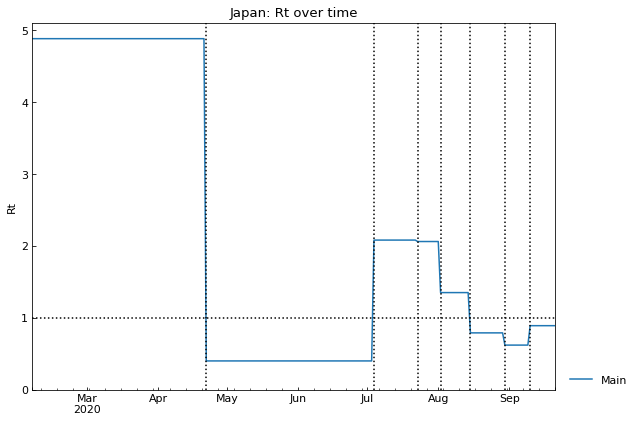

In [36]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

### Simulate the number of cases

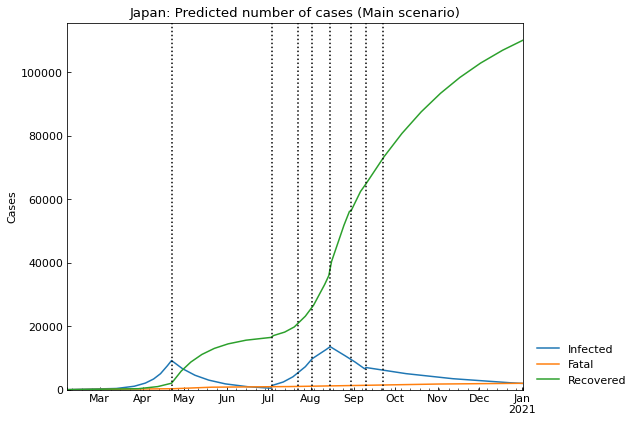

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,113322,2008,2053,109261
328,2020-12-30,113506,2010,2030,109466
329,2020-12-31,113690,2013,2008,109669
330,2021-01-01,113871,2016,1986,109869
331,2021-01-02,114049,2019,1963,110067


In [37]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.025092720266120822

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.050185440532241644

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.88   
         1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.40   
         2nd      Past  04Jul2020  22Jul2020   126529100  SIR-F  2.08   
         3rd      Past  23Jul2020  01Aug2020   126529100  SIR-F  2.06   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.35   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.79   
         6th      Past  30Aug2020  09Sep2020   126529100  SIR-F  0.62   
         7th      Past  10Sep2020  21Sep2020   126529100  SIR-F  0.89   
         8th    Future  22Sep2020  01Jan2021   126529100  SIR-F  0.89   
Medicine 0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.88   
         1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.40   
         2nd      Past  04Jul2020  22Jul2020   126529100  SIR-F  2.08   
         3rd      Past  23Jul2020  01Aug2020   126529100  SIR-F  2.06   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.35   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.79   
         6th      Past  30Aug2020  09Sep2020   126529100  SIR-F  0.62   
         7th      Past  10Sep2020  21Sep2020   126529100  SIR-F  0.89   
         8th    Future  22Sep2020  21Oct2020   126529100  SIR-F  0.89   
         9th    Future  22Oct2020  01Jan2021   126529100  SIR-F  0.45   

                   theta     kappa       rho     sigma  tau  alpha1 [-]  \
Scenario Phase                                                            
Main     0th    0.000120  0.000594  0.025352  0.004603  360       0.000   
         1st    0.084350  0.000186  0.007572  0.017066  360       0.084   
         2nd    0.001088  0.000026  0.035503  0.017018  360       0.001   
         3rd    0.000938  0.000031  0.035897  0.017340  360       0.001   
         4th    0.000487  0.000106  0.024741  0.018217  360       0.000   
         5th    0.001486  0.000191  0.021101  0.026370  360       0.001   
         6th    0.017282  0.000149  0.016330  0.025938  360       0.017   
         7th    0.002022  0.000294  0.022666  0.025093  360       0.002   
         8th    0.002022  0.000294  0.022666  0.025093  360       0.002   
Medicine 0th    0.000120  0.000594  0.025352  0.004603  360       0.000   
         1st    0.084350  0.000186  0.007572  0.017066  360       0.084   
         2nd    0.001088  0.000026  0.035503  0.017018  360       0.001   
         3rd    0.000938  0.000031  0.035897  0.017340  360       0.001   
         4th    0.000487  0.000106  0.024741  0.018217  360       0.000   
         5th    0.001486  0.000191  0.021101  0.026370  360       0.001   
         6th    0.017282  0.000149  0.016330  0.025938  360       0.017   
         7th    0.002022  0.000294  0.022666  0.025093  360       0.002   
         8th    0.002022  0.000294  0.022666  0.025093  360       0.002   
         9th    0.002022  0.000294  0.022666  0.050185  360       0.002   

                1/beta [day]  1/alpha2 [day]  1/gamma [day]      RMSLE Trials  \
Scenario Phase                                                                  
Main     0th               9             420             54   0.929576   1376   
         1st              33            1341             14   0.793123   1425   
         2nd               7            9563             14  0.0392746   1487   
         3rd               6            7997             14  0.0350864   1505   
         4th              10            2362             13  0.0929016   1812   
         5th              11            1308              9  0.0336178    210   
         6th              15            1679              9  0.0485978    216   
         7th              11             850              9  0.0186541    301   
         8th              11             850              9          -      -   
Medicine 0th     

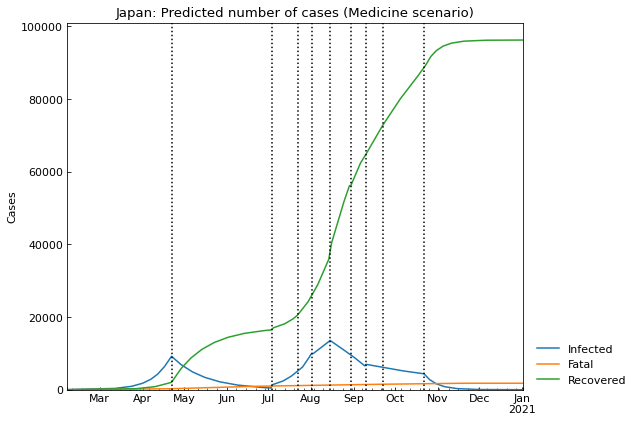

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,97995,1778,2,96215
328,2020-12-30,97996,1778,2,96216
329,2020-12-31,97996,1778,2,96216
330,2021-01-01,97996,1778,2,96216
331,2021-01-02,97996,1778,1,96217


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,9th_Rt
Main,13547,15Aug2020,1963,2019,-
Medicine,13547,15Aug2020,1,1778,0.45


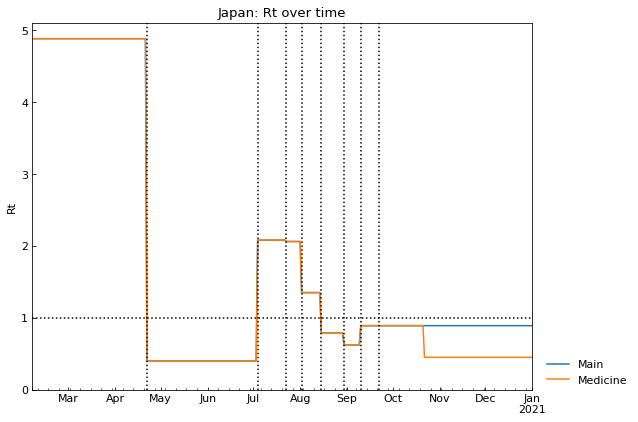

In [43]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

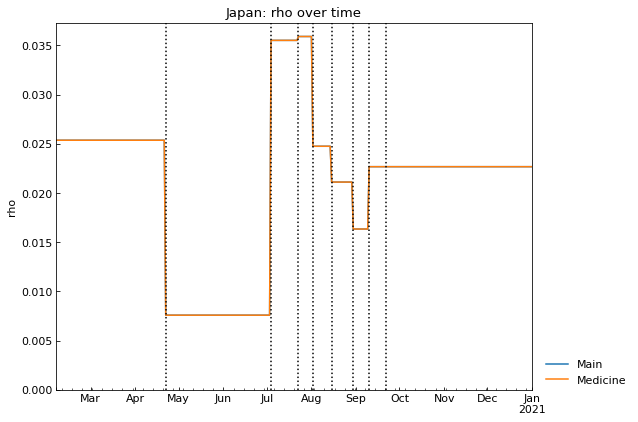

In [44]:
# version >= 2.8.0
_ = scenario.history(target="rho")

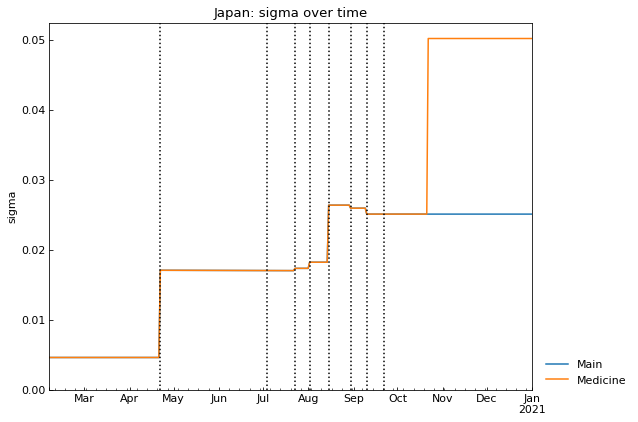

In [45]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

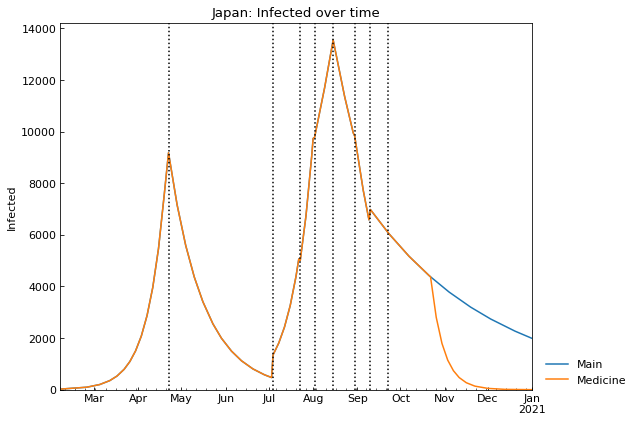

In [46]:
# version >= 2.8.0
_ = scenario.history(target="Infected")